# Neural NLP Final Project
**Authors:**  Mikhail Kuimov, Assel Yermekova, Mikhail Filitov, Varvara Shushkova

This work is inspired by the article **[The Surprising Performance of Simple Baselines for
Misinformation Detection](https://arxiv.org/pdf/2104.06952.pdf)**. In the project all the suggested approaches for automatic fake news detection were reproduced and tested on $3$ main datasets: FakeNews, Celebrity, ReCOVery. In addition, different preprocessing approaches were examined, cross-dataset experiments were conducted and also experiments on larger datasets (FakeNewsNet, NELA_GT_2018) were made to verify the quality of results. Moreover, since the texts of the articles in our datasets are pretty long, we provide the experiments on Longformer model, which was designed to have long sequences of tokens (More than $1000$. All other models have the restriction of $512$ tokens) as an input. And last but not least, we obtained the visualization of attention layers, which are the part of the majority of considered transformers, in order to get some understanding, what words are important for model to make a decision.

P.S. We ran all the experiments several times ($5$ or $3$, depending on the approach of preprocessing) to obtain more reliable results.

To get more details, please refer to our [report](https://drive.google.com/file/d/13eq-4qA7yiK37r1fneaFyZD6H2HL_Wzj/view?usp=sharing).


**Note 1:** This notebook was collected fro many other. That is why the output of the cells was not saved. 

**Note 2:** We haven't manage to run all the models with "many splits" preprocessing method on the ReCOVery dataset due to the Colab limitations. But you can try :)

**Note 3:** For NELA-GT-2018 dataset only "500 symbols" ("first_500") method works, because the dataset is to huge and there is no sense to make it even bigger.

#Loading data

There are $3$ datasets: Celebrity, FakeNews and ReCOVery. The first two are stored as `.txt` files in the corresponding folders. The third is just a `.csv` file.

In [ ]:
#FakeNews, Celebrity, ReCOVery
!gdown --id 1Mh-ahm1oaeK-LI87hZ6nesDXXWyBTbpH > /dev/null 2>&1
!unzip -o data.zip > /dev/null 2>&1

#FakeNewsNet
!gdown --id 1Ro0ajRDnVYiuX38KAXOl7StiWv4Z0fW7 > /dev/null 2>&1
!unzip -o archive.zip > /dev/null 2>&1

#NELA-GT-2018
!gdown --id 1X2k9s1mb4WW73WlpYlTDM5SolL6O188Q
!unzip -o nela-gt-2018.zip > /dev/null 2>&1

In [ ]:
!pip install transformers > /dev/null 2>&1

In [ ]:
import glob
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import transformers
from transformers import AutoTokenizer, AutoModel, pipeline
from transformers import  AdamW, BertModel
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split

from tqdm import trange
from sklearn.metrics import f1_score, recall_score, precision_score
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm

# Datasets

In [ ]:
#NELA GT HELPER FUNCTIONS

TRUE_SCORE = 70


def get_news_guard_rated_names_and_scores(nela_gt_df):
    filtered_df = nela_gt_df[nela_gt_df['NewsGuard, score'].notnull()]

    names_and_scores_df = pd.DataFrame()
    names_and_scores_df['name'] = filtered_df['Unnamed: 0']
    names_and_scores_df['score'] = filtered_df['NewsGuard, score']

    return names_and_scores_df

def read_and_set_scores(scores):
    i = 0
    f_name = 'NELA-GT-2018'

    res_df = pd.DataFrame(columns=['headline', 'content', 'label'])


    for root, dirs, files in os.walk(f_name):

        for filename in files:
            filename_parts = filename.split('--')
            
            try:
                journal = filename_parts[0]
                title = filename_parts[2]
            except:
                continue
            row = scores.loc[scores['name'] == journal]
            if (len(row)):
                with open(os.path.join(root, filename), "r") as content:
                    score = row['score'].iloc[0]
                    label = 'fake' if score  < TRUE_SCORE else 'real'
                    cur_df = pd.DataFrame([[title, content.read(), label]], columns=['headline', 'content', 'label'])
                    res_df = res_df.append(cur_df)
    return res_df

def read_nela_gt_2018():
    nela_gt_2018_labels = pd.read_csv('NELA-GT-2018/labels.csv')
    names_and_scores_df = get_news_guard_rated_names_and_scores(nela_gt_2018_labels)
    res_df = read_and_set_scores(names_and_scores_df)
    return res_df

In [ ]:
def text_splitter(text, num_words = 50):
    text_ = text.split(' ')
    num_parts = len(text_) // num_words + 1
    texts = []
    for i in range(num_parts):
        texts.append(' '.join(text_[i * num_words : (i+1) * num_words]))

    return texts


def create_dataset(dataset_name, how_preprocess = 'first_500', mode='universal'):

    def dataset_reader(news_path, lang_features=False):
        dataset = pd.DataFrame(columns=['file', 'headline', 'content', 'label'])

        regex_pattern = r"[\n.]"
        for filename in glob.glob(news_path + "*.txt"):
            with open(filename, 'r') as file:
                text = file.read().strip()
                text_splitted = re.split(regex_pattern, text)
                text_splitted = [sentence for sentence in text_splitted if len(sentence) > 0]
                headline = ''
                for index, sentence in enumerate(text_splitted):
                    headline += sentence
                    if len(headline.split(' ')) >= 5:
                        break
                content = '.'.join(text_splitted[index + 1:])
                news_file = filename.split('/')[-1]
                dataset = dataset.append({'file': news_file,
                                          'headline': headline.strip(),
                                          'content': content.strip(),
                                          'label': ''.join(i for i in news_file.split('.')[-2] if not i.isdigit())}, ignore_index=True)

        if lang_features:
            for lang in TARGET_LANGS:
                dataset.insert(len(dataset.columns), lang, 0)

        return dataset

    if dataset_name == 'celebrity':
        news_fake = dataset_reader('/content/data/celebrityDataset/fake/') # /content/data/fakeNewsDataset/fake/
        news_legit = dataset_reader('/content/data/celebrityDataset/legit/') # /content/data/celebrityDataset/legit/
        news_df = news_fake.append(news_legit, ignore_index=True)
    elif dataset_name == 'fakeNews':
        news_fake = dataset_reader('/content/data/fakeNewsDataset/fake/') # /content/data/fakeNewsDataset/fake/
        news_legit = dataset_reader('/content/data/fakeNewsDataset/legit/') # /content/data/celebrityDataset/legit/
        news_df = news_fake.append(news_legit, ignore_index=True)
    elif dataset_name == 'fakeNewsNet':
        pol_fake = pd.read_csv('BuzzFeed_fake_news_content.csv')
        pol_real = pd.read_csv('BuzzFeed_real_news_content.csv')
        dataset_fake = pd.DataFrame(columns=['file', 'headline', 'content', 'label'])

        dataset_fake['headline'] = pol_fake['title']
        dataset_fake['content'] = pol_fake['text']
        dataset_fake['label'] = 'fake'

        dataset_real = pd.DataFrame(columns=['file', 'headline', 'content', 'label'])
        dataset_real['headline'] = pol_real['title']
        dataset_real['content'] = pol_real['text']
        dataset_real['label'] = 'real'

        frames = [dataset_fake, dataset_real]
        news_df = pd.concat(frames)
    elif dataset_name == 'nela_gt_2018':
        news_df = read_nela_gt_2018()
        if how_preprocess == 'many_splits':
            raise ValueError('Method is not supported for this dataset.')
    elif dataset_name == 'recovery':
        news_df = pd.read_csv('/content/data/recovery-news-data.csv').rename(columns={'news_id': 'file',
                                                                                      'title': 'headline',
                                                                                      'body_text' : 'content',
                                                                                      'reliability' : 'label'})[['file', 'headline', 'content', 'label']]
        
        news_df.label = news_df.label.apply(lambda x: 'legit' if x == 1 else 'fake')
        news_df.dropna(inplace=True)

    def preprocess(news_df, how_preprocess):
        index_vocab = {}
        if how_preprocess == 'first_500':
            text_size = 500
            news_df['headline_plus_content'] = news_df[['headline', 'content']].apply(lambda x: ' '.join([x[0], x[1][:text_size]]), axis=1)
        elif how_preprocess == 'many_splits':
            news_df_new = pd.DataFrame(columns=['file', 'headline', 'content', 'label', 'headline_plus_content'])
            print('Making splits...')
            for i in tqdm(range(news_df.shape[0])):
                line = news_df.iloc[i]
                if line['file'] not in index_vocab:
                    index_vocab[line['file']] = len(index_vocab)
                texts = text_splitter(line['content'])
                for text in texts:
                    line['headline_plus_content'] = ' '.join([line['headline'], text])
                    news_df_new.loc[news_df_new.shape[0]] = line.values
            news_df = news_df_new.copy()
        else:
            raise ValueError('No such method for preprocessing')
        
        news_df['label'] = 1.*(news_df['label'] == 'fake')
        
        if how_preprocess == 'many_splits':
            news_df['file'] = news_df['file'].apply(lambda x: index_vocab[x])
        tr_x, val_x, tr_y, val_y, tr_i, val_i = train_test_split(news_df['headline_plus_content'].values, news_df['label'].values, news_df['file'].values, random_state=42, test_size=0.25, shuffle=True)
        return tr_x, val_x, tr_y, val_y, tr_i, val_i
    

    tr_x, val_x, tr_y, val_y, tr_i, val_i = preprocess(news_df, how_preprocess)

    return tr_x, val_x, tr_y, val_y, tr_i, val_i

# Training models

In [ ]:
class BERT_for_FND(nn.Module):
    def __init__(self, pretrained_model, linear_layer_size):
        super(BERT_for_FND, self).__init__()
        self.model = pretrained_model
        self.fc = nn.Linear(linear_layer_size, 2)

    def forward(self, input_ids, attention_mask):
        #we have to take only [CLS], it's first, from the output layer
        x = self.model(input_ids, attention_mask)['last_hidden_state'][:,0]
        logits = self.fc(x)
        return logits

In [ ]:
class STLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, max_mul, ratio, steps_per_cycle, decay=1, last_epoch=-1):
        self.max_mul = max_mul - 1
        self.turning_point = steps_per_cycle // (ratio + 1)
        self.steps_per_cycle = steps_per_cycle
        self.decay = decay
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        residual = self.last_epoch % self.steps_per_cycle
        multiplier = self.decay ** (self.last_epoch // self.steps_per_cycle)
        if residual <= self.turning_point:
            multiplier *= self.max_mul * (residual / self.turning_point)
        else:
            multiplier *= self.max_mul * (
                (self.steps_per_cycle - residual) /
                (self.steps_per_cycle - self.turning_point))
        return [lr * (1 + multiplier) for lr in self.base_lrs]

In [ ]:
def train_model(model, batch_size, batch_size_val, linear_layer_size, num_epochs, tr_x, val_x, tr_y, val_y, tr_i=None, val_i=None,
                cross_test=False, dataset_train_name='celebrity', dataset_test_name='recovery', how_preprocess = 'first_500'):
    train_labels = torch.tensor([[1.,0.] if x == 1 else [0.,1.] for x in tr_y])
    val_labels = torch.tensor([[1.,0.] if x == 1 else [0.,1.] for x in val_y])


    tokens_info = tokenizer(list(tr_x), padding=True, truncation=True, return_tensors="pt")
    train_data = TensorDataset(tokens_info['input_ids'], tokens_info['attention_mask'], train_labels)

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    tokens_info = tokenizer(list(val_x), padding=True, truncation=True, return_tensors="pt")
    valid_data = TensorDataset(tokens_info['input_ids'], tokens_info['attention_mask'], val_labels)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size_val)

    classifier = BERT_for_FND(model, linear_layer_size)
    optimizer = AdamW(classifier.parameters(), lr=1e-5)
    scheduler = STLR(optimizer, 2, 32, 500, 0.38)
    criterion = BCEWithLogitsLoss()

    torch.cuda.empty_cache()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    classifier.to(device)
    max_grad_norm = 1.0
    loss_values, validation_loss_values = [], []
    prev_metric = 0
    best_r, best_p = 0, 0
    try:
        for ep in trange(num_epochs, desc="Epoch"):

            classifier.train()
            total_loss = 0

            for step, batch in enumerate(train_dataloader):

                batch = tuple(t.to(device) for t in batch)
                
                input_ids, attention_mask, labels  = batch

                optimizer.zero_grad()
                logits = classifier(input_ids, attention_mask)
                
                loss = criterion(logits, labels)
                loss.backward()
                total_loss += loss.item()

                # Clipping the norm of the gradient to help prevent the "exploding gradients" 
                torch.nn.utils.clip_grad_norm_(parameters=classifier.parameters(), max_norm=max_grad_norm)

                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloader)
            clear_output(wait=True)
            print("\nAverage train loss: {}".format(avg_train_loss))

            loss_values.append(avg_train_loss)


            classifier.eval()
            eval_loss, eval_accuracy = 0, 0
            precisions , recalls, f1_scores = [], [], []
            for batch in valid_dataloader:
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, labels = batch

                with torch.no_grad():
                    logits = classifier(input_ids, attention_mask)

                eval_loss += criterion(logits, labels)
                labels = labels.argmax(dim=1).detach().cpu().numpy()
                prediction = torch.sigmoid(logits).argmax(dim=1).detach().cpu().numpy()

                precisions.append(precision_score(labels, prediction))
                recalls.append(recall_score(labels, prediction))
                f1_scores.append(f1_score(labels, prediction))

            eval_loss = eval_loss / len(valid_dataloader)


            eval_metric1 = np.mean(precisions)
            eval_metric2 = np.mean(recalls)
            eval_metric3 = np.mean(f1_scores)
            eval_metrics = [eval_metric1, eval_metric2, eval_metric3]
            validation_loss_values.append(eval_loss)
            print("Validation loss: {}".format(eval_loss))
            metrics = ['precision', 'recall', 'f1 score']
            for metric, name in zip(eval_metrics, metrics):
                print(f"{name}: {metric}")
            
            if prev_metric < eval_metric3:
                torch.save(classifier.state_dict(), "model_best.pth")
                print("Best model saved at epoch {}".format(ep))
                prev_metric = eval_metric3
                best_r = eval_metric2
                best_p = eval_metric1
            print('Best precission score: ', best_p)
            print('Best recall score: ', best_r)
            print('Best f1 score: ', prev_metric)
            torch.save(classifier.state_dict(), "model_curr.pth")

            plt.figure(figsize=(10,8))
            plt.plot(loss_values, label='Train loss')
            plt.plot(validation_loss_values, label='Validation loss')
            plt.xlabel('#epoch')
            plt.ylabel('Loss value')
            plt.grid()
            plt.legend()
            plt.show()
    except KeyboardInterrupt:
        pass

    if cross_test:

        print('Cross test info:')
        print(f'Dataset to test: {dataset_test_name}')
        classifier = BERT_for_FND(model, linear_layer_size)
        classifier.to(device)
        classifier.load_state_dict(torch.load('/content/model_best.pth'))
        if dataset_train_name == dataset_test_name:
            x = list(val_x)
            y = val_y
            ind = val_i
        elif dataset_test_name == 'recovery':
            tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset(dataset_test_name, how_preprocess=how_preprocess)
            x = list(val_x)
            y = val_y
            ind = val_i
        else:
            tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset(dataset_test_name, how_preprocess=how_preprocess)
            x = list(tr_x) + list(val_x)
            y = list(tr_y) + list(val_y)
            ind = list(tr_i) + list(val_i)
        val_labels = torch.tensor([[1.,0.] if el == 1 else [0.,1.] for el in y])
        tokens_info = tokenizer(x, padding=True, truncation=True, return_tensors="pt")
        if how_preprocess == 'many_splits':
            indices = torch.tensor(ind)
            valid_data = TensorDataset(tokens_info['input_ids'], tokens_info['attention_mask'], val_labels, indices)
        else:
            tokens_info = tokenizer(x, padding=True, truncation=True, return_tensors="pt")
            valid_data = TensorDataset(tokens_info['input_ids'], tokens_info['attention_mask'], val_labels)

        valid_dataloader = DataLoader(valid_data, batch_size=batch_size_val, shuffle=True)

        classifier.eval()
        eval_loss, eval_accuracy = 0, 0
        precisions , recalls, f1_scores = [], [], []
        all_predictions = []
        all_indices = []
        all_labels = []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            if how_preprocess == 'many_splits':
                input_ids, attention_mask, labels, indices = batch
            else:
                input_ids, attention_mask, labels = batch

            with torch.no_grad():
                logits = classifier(input_ids, attention_mask)

            eval_loss += criterion(logits, labels)
            labels = labels.argmax(dim=1).detach().cpu().numpy()
            prediction = torch.sigmoid(logits).argmax(dim=1).detach().cpu().numpy()
            if how_preprocess == 'many_splits':
                indices = indices.detach().cpu().numpy()
                all_indices = all_indices + list(indices)
                all_labels = all_labels + list(labels)
                all_predictions = all_predictions + list(prediction)

            precisions.append(precision_score(labels, prediction))
            recalls.append(recall_score(labels, prediction))
            f1_scores.append(f1_score(labels, prediction))

        eval_loss = eval_loss / len(valid_dataloader)


        eval_metric1 = np.mean(precisions)
        eval_metric2 = np.mean(recalls)
        eval_metric3 = np.mean(f1_scores)
        eval_metrics = [eval_metric1, eval_metric2, eval_metric3]
        print("Validation loss: {}".format(eval_loss))
        metrics = ['precision', 'recall', 'f1 score']
        for metric, name in zip(eval_metrics, metrics):
            print(f"{name}: {metric}")
        


        if how_preprocess == 'many_splits':
            dff = pd.DataFrame(np.array([all_indices, all_predictions, all_labels]).T,
                              columns=['indices', 'predictions', 'labels'])
            dff_agregated = dff.groupby(by = ['indices']).mean()
            dff_agregated['predictions'] = (dff_agregated['predictions'] >= 0.5).values.astype('float')
            precision = precision_score(dff_agregated['labels'], dff_agregated['predictions'])
            recall = recall_score(dff_agregated['labels'], dff_agregated['predictions'])
            f1_score_ = f1_score(dff_agregated['labels'], dff_agregated['predictions'])
            print('Precission score after aggregation: ', precision)
            print('Recall score after aggregation: ', recall)
            print('f1 score after aggregation: ', f1_score_)
            return f1_score_, precision, recall

# Train

## Bert base

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=10, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=10, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=10, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

## Bert tiny


Average train loss: 0.02908349757315591
Validation loss: 0.10040974617004395
precision: 0.9743631656693941
recall: 0.9730673802901182
f1 score: 0.9728048439362342
Best model saved at epoch 49
Best precission score:  0.9743631656693941
Best recall score:  0.9730673802901182
Best f1 score:  0.9728048439362342


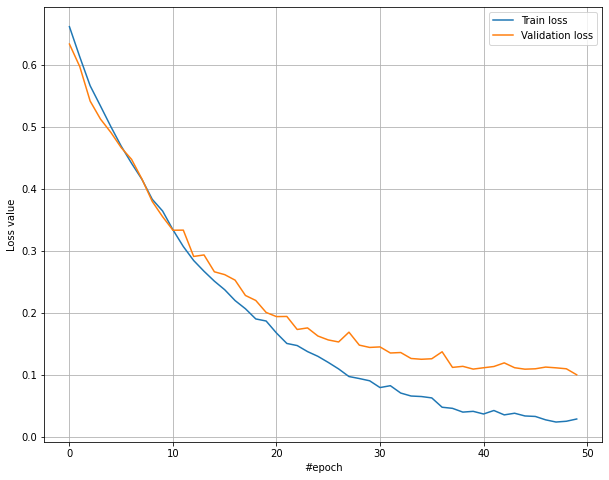

Epoch: 100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


Cross test info:
Dataset to test: celebrity
Validation loss: 0.09496532380580902
precision: 0.9769989058574926
recall: 0.9747260849644296
f1 score: 0.9750416605326727
Precission score after aggregation:  0.9567307692307693
Recall score after aggregation:  0.9802955665024631
f1 score after aggregation:  0.9683698296836984
----------------------------------------------------------------------------------------------------
Final results:
f1 score: 0.9714703541468325 +- 0.008214270513403605
precission: 0.9660633212313017 +- 0.013496359520550779
recall: 0.9770114942528737 +- 0.004644379515182572


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'google/bert_uncased_L-2_H-128_A-2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=128,
                num_epochs=50, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'google/bert_uncased_L-2_H-128_A-2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=128,
                num_epochs=50, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'google/bert_uncased_L-2_H-128_A-2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=128,
                num_epochs=50, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

## Roberta


Average train loss: 0.03529409451293759
Validation loss: 0.05271473154425621
precision: 0.9908788515406163
recall: 0.9901186790505676
f1 score: 0.9900606378280439
Best model saved at epoch 3
Best precission score:  0.9908788515406163
Best recall score:  0.9901186790505676
Best f1 score:  0.9900606378280439


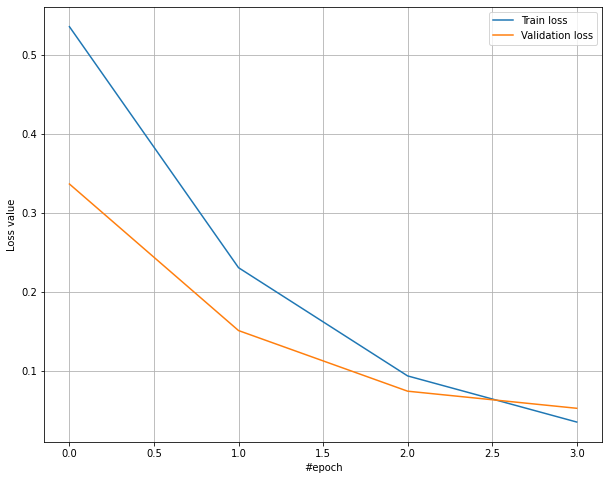

Epoch: 100%|██████████| 4/4 [11:00<00:00, 165.16s/it]


Cross test info:
Dataset to test: celebrity
Validation loss: 0.05272326245903969
precision: 0.9920277603019819
recall: 0.9909220295108667
f1 score: 0.991257019661677
Precission score after aggregation:  0.9901477832512315
Recall score after aggregation:  0.9901477832512315
f1 score after aggregation:  0.9901477832512315
----------------------------------------------------------------------------------------------------
Final results:
f1 score: 0.9878177014608799 +- 0.00515030780911768
precission: 0.9808097232464922 +- 0.013240175634561646
recall: 0.9950738916256157 +- 0.004022150644964163


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=4, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')



Average train loss: 0.1613867160049267
Validation loss: 0.3857274055480957
precision: 0.8288860266449628
recall: 0.9539247517188695
f1 score: 0.8843931843174208
Best model saved at epoch 3
Best precission score:  0.8288860266449628
Best recall score:  0.9539247517188695
Best f1 score:  0.8843931843174208


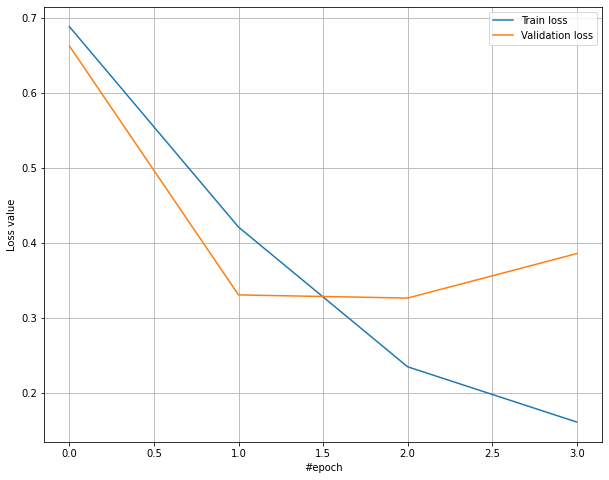

Epoch: 100%|██████████| 4/4 [03:35<00:00, 53.92s/it]


Cross test info:
Dataset to test: fakeNews
Validation loss: 0.3865407705307007
precision: 0.8338266738761116
recall: 0.9558006535947712
f1 score: 0.8869698297927576
Precission score after aggregation:  0.82
Recall score after aggregation:  0.9534883720930233
f1 score after aggregation:  0.8817204301075269
----------------------------------------------------------------------------------------------------
Final results:
f1 score: 0.8862152050299046 +- 0.009077434719932815
precission: 0.8708807134894091 +- 0.04209125732848871
recall: 0.9069767441860465 +- 0.05023829998765782


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=4, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')


## COVID-Twitter-BERT

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'digitalepidemiologylab/covid-twitter-bert-v2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=16,
                batch_size_val=16,
                linear_layer_size=1024,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')



Average train loss: 0.027233707229791595
Validation loss: 0.8282259106636047
precision: 0.8266439909297051
recall: 0.9099395313681029
f1 score: 0.8624299472375544
Best model saved at epoch 5
Best precission score:  0.8266439909297051
Best recall score:  0.9099395313681029
Best f1 score:  0.8624299472375544


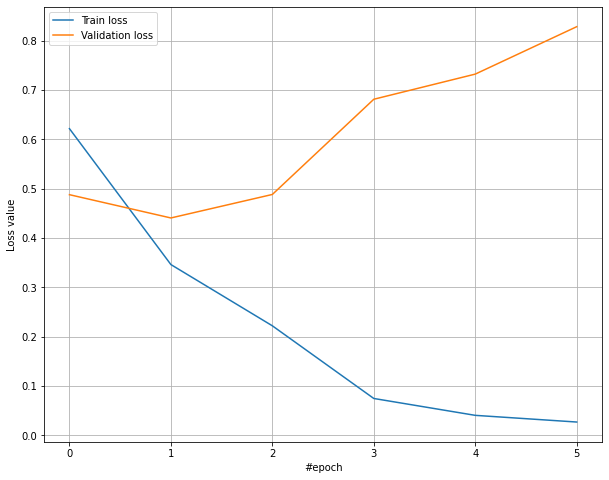

Epoch: 100%|██████████| 6/6 [11:27<00:00, 114.61s/it]


Cross test info:
Dataset to test: fakeNews
Validation loss: 0.831565797328949
precision: 0.8251271215556929
recall: 0.9144317322888751
f1 score: 0.8622547456802211
Precission score after aggregation:  0.8206896551724138
Recall score after aggregation:  0.9224806201550387
f1 score after aggregation:  0.8686131386861314
----------------------------------------------------------------------------------------------------
Final results:
f1 score: 0.8716797104886383 +- 0.005950703878173896
precission: 0.820089196423632 +- 0.007342919604326525
recall: 0.9302325581395349 +- 0.006329430859904864


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'digitalepidemiologylab/covid-twitter-bert-v2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=16,
                batch_size_val=16,
                linear_layer_size=1024,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'digitalepidemiologylab/covid-twitter-bert-v2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=16,
                batch_size_val=16,
                linear_layer_size=1024,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')


## Albert

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'albert-large-v2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=1024,
                num_epochs=4, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'albert-large-v2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=1024,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'albert-large-v2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=1024,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

## Bertweet

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'vinai/bertweet-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=16,
                batch_size_val=16,
                linear_layer_size=768,
                num_epochs=4, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'vinai/bertweet-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=16,
                batch_size_val=16,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'vinai/bertweet-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=16,
                batch_size_val=16,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

## johngiorgi/declutr-base


Average train loss: 0.0010064309050600666
Validation loss: 1.0955204963684082
precision: 0.7759036102786103
recall: 0.8920454545454546
f1 score: 0.8084640746250653
Best precission score:  0.7811119436119436
Best recall score:  0.9285037878787878
Best f1 score:  0.8287021698631606


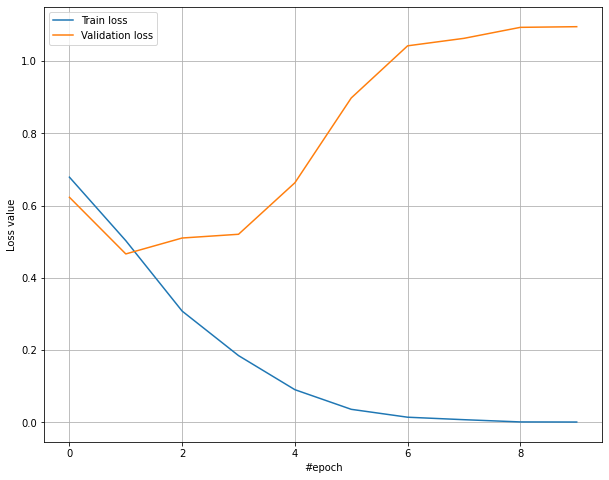




Epoch: 100%|██████████| 10/10 [01:47<00:00, 10.77s/it]


Cross test info:
Dataset to test: recovery
Validation loss: 1.51997971534729
precision: 0.722683869949495
recall: 0.9762025301087801
f1 score: 0.8272647427180339
Best precission score:  0.722683869949495
Best recall score:  0.9762025301087801
Best f1 score:  0.8272647427180339


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'johngiorgi/declutr-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')         

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'johngiorgi/declutr-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')         

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'johngiorgi/declutr-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=10, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')         

## Funnel Transformer


Average train loss: 0.0004495589067422164
Validation loss: 1.2289336919784546
precision: 0.7847177128427129
recall: 0.9034090909090909
f1 score: 0.8202842500636618
Best precission score:  0.7822375541125541
Best recall score:  0.8991477272727273
Best f1 score:  0.8250758805346401


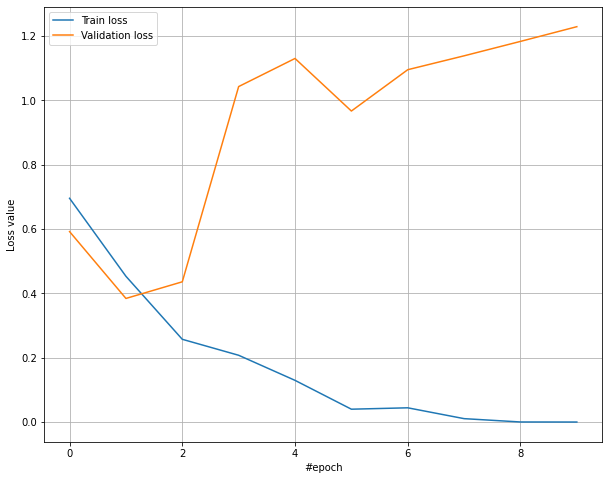




Epoch: 100%|██████████| 10/10 [01:43<00:00, 10.34s/it]


Cross test info:
Dataset to test: recovery
Validation loss: 2.171738386154175
precision: 0.697294805888556
recall: 0.8667963980463981
f1 score: 0.7683715162204023
Best precission score:  0.697294805888556
Best recall score:  0.8667963980463981
Best f1 score:  0.7683715162204023


In [ ]:
from transformers import FunnelTokenizer, FunnelModel

results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='many_splits')
    model_name = 'funnel-transformer/small-base'
    tokenizer = FunnelTokenizer.from_pretrained(model_name)
    model = FunnelModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')                  



Average train loss: 0.028954771473882316
Validation loss: 1.083480715751648
precision: 0.7866567460317461
recall: 0.8302579365079366
f1 score: 0.7999732905982906
Best precission score:  0.7416531385281386
Best recall score:  0.9222718253968254
Best f1 score:  0.8169056637806638


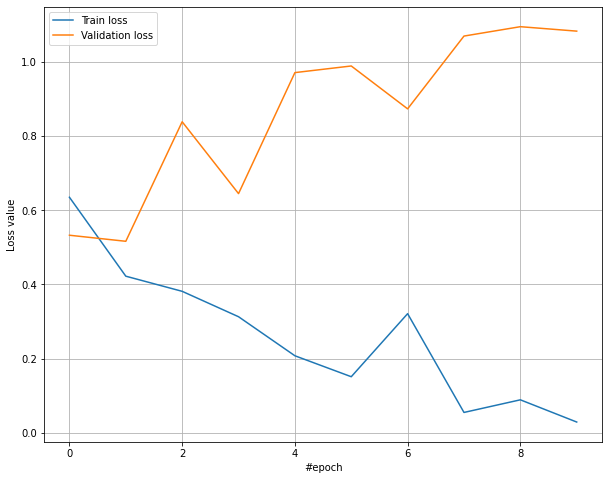

Epoch: 100%|██████████| 10/10 [02:39<00:00, 15.93s/it]


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='many_splits')
    model_name = 'funnel-transformer/small-base'
    tokenizer = FunnelTokenizer.from_pretrained(model_name)
    model = FunnelModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')                  



Average train loss: 0.010932542314357738
Validation loss: 0.6620542407035828
precision: 0.8963678682428682
recall: 0.9679560023310023
f1 score: 0.9282775059960331
Best precission score:  0.9421826437451437
Best recall score:  0.9464681152181151
Best f1 score:  0.9416225716475162


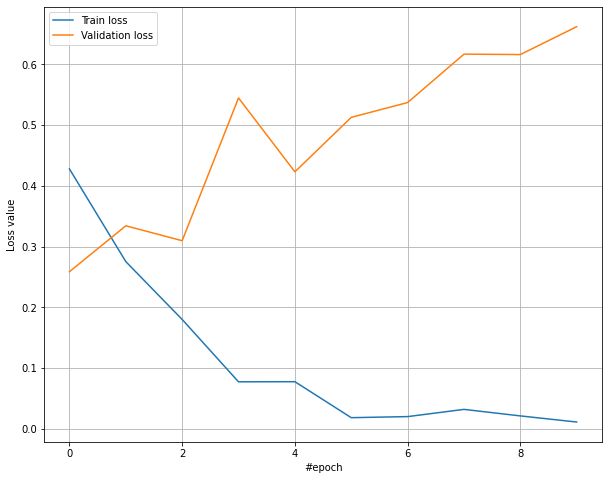

Epoch: 100%|██████████| 10/10 [08:56<00:00, 53.65s/it]


In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='many_splits')
    model_name = 'funnel-transformer/small-base'
    tokenizer = FunnelTokenizer.from_pretrained(model_name)
    model = FunnelModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=32,
                batch_size_val=32,
                linear_layer_size=768,
                num_epochs=6, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='many_splits')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')                  


## Elmo

In [ ]:
!pip install allennlp-models==v2.4.0 > /dev/null 2>&1
!pip install torchsnooper > /dev/null 2>&1

In [ ]:
import json
from tqdm import tqdm

### Dataset preparation

### Celebrity and FakeNews datasets

In [ ]:
#function for reading data from .txt files
def dataset_reader(news_path, lang_features=False):
    dataset = pd.DataFrame(columns=['file', 'headline', 'content', 'label'])

    regex_pattern = r"[\n.]"
    for filename in glob.glob(news_path + "*.txt"):
        with open(filename, 'r') as file:
            text = file.read().strip()
            text_splitted = re.split(regex_pattern, text)
            text_splitted = [sentence for sentence in text_splitted if len(sentence) > 0]
            headline = ''
            for index, sentence in enumerate(text_splitted):
                headline += sentence
                if len(headline.split(' ')) >= 5:
                    break
            content = '.'.join(text_splitted[index + 1:])
            news_file = filename.split('/')[-1]
            dataset = dataset.append({'file': news_file,
                                      'headline': headline.strip(),
                                      'content': content.strip(),
                                      'label': ''.join(i for i in news_file.split('.')[-2] if not i.isdigit())}, ignore_index=True)

    if lang_features:
        for lang in TARGET_LANGS:
            dataset.insert(len(dataset.columns), lang, 0)

    return dataset

In [ ]:
news_fake = dataset_reader('/content/data/celebrityDataset/fake/') # /content/data/fakeNewsDataset/fake/
news_legit = dataset_reader('/content/data/celebrityDataset/legit/') # /content/data/celebrityDataset/legit/
news_df = news_fake.append(news_legit, ignore_index=True)

In [ ]:
news_df.head(5)

file  ... label
0  098fake.txt  ...  fake
1  047fake.txt  ...  fake
2  185fake.txt  ...  fake
3  134fake.txt  ...  fake
4  076fake.txt  ...  fake

[5 rows x 4 columns]

### ReCOVery dataset

In [ ]:
news_df = pd.read_csv('/content/data/recovery-news-data.csv').rename(columns={'news_id': 'file', 'title': 'headline', 'body_text' : 'content', 'reliability' : 'label'})[['file', 'headline', 'content', 'label']]

In [ ]:
news_df.label = news_df.label.apply(lambda x: 'legit' if x == 1 else 'fake')

In [ ]:
news_df.head(3)

file  ...  label
0     0  ...  legit
1     1  ...  legit
2     2  ...  legit

[3 rows x 4 columns]

In [ ]:
news_df.dropna(inplace=True)

###Preparing data for training

In [ ]:
text_size = 500
news_df['headline_plus_content'] = news_df[['headline', 'content']].apply(lambda x: ' '.join([x[0], x[1][:text_size]]), axis=1)

In [ ]:
news_df['label'] = 1.*(news_df['label'] == 'fake')

In [ ]:
tr_x, val_x, tr_y, val_y = train_test_split(news_df['headline_plus_content'].values, news_df['label'].values, random_state=42, test_size=0.25, shuffle=True)

In [ ]:
_, val_x, _, val_y = train_test_split(news_df['headline_plus_content'].values, news_df['label'].values, random_state=42, test_size=0.25, shuffle=True)

Creating json files to read with the corresponding AllenNLP reader

In [ ]:
data = []


for text, label in tqdm(zip(tr_x, tr_y)):
    data.append({'text' : text, 'label' : label})

with open('data_train.json', 'w') as outfile:
    for d in data:
        json.dump(d, outfile)
        outfile.write('\n')

375it [00:00, 153750.15it/s]


In [ ]:
data = []


for text, label in tqdm(zip(val_x, val_y)):
    data.append({'text' : text, 'label' : label})

with open('data_val.json', 'w') as outfile:
    for d in data:
        json.dump(d, outfile)
        outfile.write('\n')

507it [00:00, 332527.31it/s]


In [ ]:
from allennlp.data.token_indexers import ELMoTokenCharactersIndexer
from allennlp.data.dataset_readers.text_classification_json import TextClassificationJsonReader

indexer = ELMoTokenCharactersIndexer('elmo')
reader = TextClassificationJsonReader(token_indexers={'tokens': indexer})

Making data loaders

In [ ]:
from allennlp.data.data_loaders.simple_data_loader import SimpleDataLoader
train_dataloder = SimpleDataLoader.from_dataset_reader(reader=reader, 
                                                       data_path="/content/data_train.json", batch_size=32, shuffle=True)
val_dataloder = SimpleDataLoader.from_dataset_reader(reader=reader, 
                                                       data_path="/content/data_val.json", batch_size=32, shuffle=True)

loading instances: 375it [00:15, 24.77it/s]
loading instances: 507it [00:20, 25.02it/s]


The vocaulary, created straight from the data has given poor quality of 0.5 accuracy, that is why it was decided to use one from BERT.

In [ ]:
from allennlp.data.vocabulary import Vocabulary

vocab = Vocabulary.from_pretrained_transformer('bert-large-cased')

Indexing data with vocabualary.

In [ ]:
train_dataloder.index_with(vocab)
val_dataloder.index_with(vocab)

Setting up the model components.

In [ ]:
from allennlp.modules.seq2seq_encoders.pytorch_seq2seq_wrapper import LstmSeq2SeqEncoder
from allennlp.modules.token_embedders.elmo_token_embedder import ElmoTokenEmbedder
from allennlp.modules.text_field_embedders.basic_text_field_embedder import BasicTextFieldEmbedder

embedder = ElmoTokenEmbedder(options_file = 'https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json',
                             weight_file = 'https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5')
text_field_embedder = BasicTextFieldEmbedder({'tokens': embedder})
encoder = LstmSeq2SeqEncoder(input_size=embedder.get_output_dim(), hidden_size=300, bidirectional=True, num_layers = 1)

downloading: 100%|##########| 374434792/374434792 [00:12<00:00, 29834832.41B/s]


In [ ]:
device = torch.device('cuda:0')

Here is the modified class taken from the [github](https://github.com/ComplexData-MILA/misinfo-baselines) of reference article authors. However, they doesn't have metrics class there. So, we've found one on the endless expanses of the Internet and adapted it so that it worked correctly, taking AllenNLP accuracy implementation as a reference. 
However, second time, the class was throwing some errors. That is why it was fixed to match the dimensions.

In [ ]:
from typing import Dict, Optional

from overrides import overrides
import torch

from allennlp.data import TextFieldTensors, Vocabulary
from allennlp.models import Model, BasicClassifier
from allennlp.nn import util

from sklearn.metrics import f1_score, recall_score, precision_score

import torchsnooper


class SklearnClassificationMetric(object):
    def __init__(self, score_fn, gt_logits=True, pred_logits=True, **kwargs):
        """
        Wraps an score function as a metric
        Parameters
        ----------
        score_fn : function
            function which should be wrapped
        gt_logits : bool
            whether given ``y_true`` are logits or not
        pred_logits : bool
            whether given ``y_pred`` are logits or not
        **kwargs:
            variable number of keyword arguments passed to score_fn function
        """
        self._score_fn = score_fn
        self._gt_logits = gt_logits
        self._pred_logits = pred_logits
        self.kwargs = kwargs
        self.value = []

    def __call__(self, y_true, y_pred, **kwargs):
        """
        Compute metric with score_fn
        Parameters
        ----------
        y_true: np.ndarray
            ground truth data
        y_pred: np.ndarray
            predictions of network
        kwargs:
            variable number of keyword arguments passed to score_fn
        Returns
        -------
        float
            result from score function
        """

        if self._gt_logits:
            y_true = np.argmax(y_true, axis=-1)

        if self._pred_logits:
            y_pred = np.argmax(y_pred, axis=-1)

        #print(y_true, y_pred)
        self.value.append(self._score_fn(y_true=y_true, y_pred=y_pred, **kwargs, **self.kwargs))
        return self._score_fn(y_true=y_true, y_pred=y_pred,
                              **kwargs, **self.kwargs)
        
    def get_metric(self, reset: bool = False):

        if len(self.value) > 0:
            m = np.array(self.value).mean()
        else:
            m = 0.0

        if reset:
            self.reset()

        return m

    def reset(self):
        self.value = []

        


class SklearnF1Score(SklearnClassificationMetric):
    """
    F1 Score
    """

    def __init__(self, gt_logits=True, pred_logits=True, **kwargs):
        super().__init__(f1_score, gt_logits, pred_logits, **kwargs)


class SklearnPrecisionScore(SklearnClassificationMetric):
    """
    Precision Score
    """

    def __init__(self, gt_logits=True, pred_logits=True, **kwargs):
        super().__init__(precision_score, gt_logits, pred_logits, **kwargs)


class SklearnRecallScore(SklearnClassificationMetric):
    """
    Precision Score
    """

    def __init__(self, gt_logits=True, pred_logits=True, **kwargs):
        super().__init__(recall_score, gt_logits, pred_logits, **kwargs)



# @Model.register("metrics_classifier_")
class BasicClassifierWithMetrics(BasicClassifier):
    def __init__(self, f1_average: str = "weighted", **kwargs) -> None:
        super().__init__(**kwargs)
        self._f1 = SklearnF1Score(average=f1_average)
        self._precision = SklearnPrecisionScore(average=f1_average)
        self._recall = SklearnRecallScore(average=f1_average)

    def _get_logits(self, tokens: TextFieldTensors) -> torch.Tensor:
        embedded_text = self._text_field_embedder(tokens)
        mask = util.get_text_field_mask(tokens)

        if self._seq2seq_encoder:
            embedded_text = self._seq2seq_encoder(embedded_text, mask=mask)

        embedded_text = self._seq2vec_encoder(embedded_text, mask=mask)

        if self._dropout:
            embedded_text = self._dropout(embedded_text)

        if self._feedforward is not None:
            embedded_text = self._feedforward(embedded_text)

        logits = self._classification_layer(embedded_text)
        return logits, embedded_text

    @overrides
    def forward(self, tokens: TextFieldTensors, label: torch.IntTensor = None) -> Dict[str, torch.Tensor]:
        logits, embedded_text = self._get_logits(tokens)
        probs = torch.nn.functional.softmax(logits, dim=-1)

        output_dict = {"probs": probs, "true_label":label.float()} # "embedding": embedded_text,
        if label is not None:
            device = label.device
            label_ = torch.tensor([[0.,1.] if x == 1 else [1.,0.] for x in label.cpu().numpy()]).to(device)

            loss = self._loss(logits.mean(dim=1), label.long())
            output_dict["loss"] = loss

            self._accuracy(probs.mean(dim=1).cpu(), label.cpu())
            self._f1(probs.mean(dim=1).cpu().detach(), label_.cpu().detach())
            self._precision(probs.mean(dim=1).cpu().detach(), label_.cpu().detach())
            self._recall(probs.mean(dim=1).cpu().detach(), label_.cpu().detach())
        return output_dict

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        metrics = super().get_metrics(reset)
        metrics = {"accuracy": self._accuracy.get_metric(reset), "f1 score" : self._f1.get_metric(reset),
                   "precision score" : self._precision.get_metric(reset),
                   "recall score" : self._recall.get_metric(reset)}
        return metrics

    default_predictor = "text_classifier"

In [ ]:
model = BasicClassifierWithMetrics(text_field_embedder=text_field_embedder, 
                      vocab=vocab,
                      seq2vec_encoder=encoder
                     ).cuda(device=device)

In [ ]:
torch.cuda.empty_cache()

### Training

All the parameters were taken the same as in the article that was taken for reproduction.

In [ ]:
import torch.optim as optim
from allennlp.training.learning_rate_schedulers import LinearWithWarmup, ReduceOnPlateauLearningRateScheduler, SlantedTriangular
from allennlp.training import GradientDescentTrainer
from torch.utils.data import DataLoader
from allennlp.data import allennlp_collate
from datetime import datetime
import math



num_epochs = 10
batch_size = 32
steps_per_epoch = math.ceil(len(tr_x) / batch_size)

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.1)
lr_scheduler = SlantedTriangular(optimizer, num_epochs=num_epochs, num_steps_per_epoch=steps_per_epoch, cut_frac=0.06)


date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')


trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=train_dataloder,
    validation_data_loader=val_dataloder,
    num_epochs=num_epochs,
    cuda_device=device,
    learning_rate_scheduler=lr_scheduler,
    num_gradient_accumulation_steps=1,
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy: 0.1973, f1 score: 0.1319, precision score: 0.1063, recall score: 0.2121, batch_loss: 0.6822, loss: 0.7085 ||: 100%|##########| 12/12 [00:06<00:00,  1.85it/s]
accuracy: 0.3314, f1 score: 0.1704, precision score: 0.1166, recall score: 0.3303, batch_loss: 0.7058,

# Big datasets

Actually only NELA-GT appeared to be big. FakeNewsNet can be collected straight from Twitter, but there is a resriction on the number of samples, which can be collected. We managed to collect only $400$ samples. That is why it has lost the property of being big, neede for this experiments. Still, you can try it changing dataset name to "fakeNewsNet" and get the results very similar to ones obtained on our main datasets.

It was hard to run the huge models on such big dataset as NELA-GT due to the colab restrictions. That is why we managed to obtain the results only for subset od our model list. Also the batch size was decreased to $8$ and it was taken only $100000$ samples due to the same reason.
Also, it was decided to test only with "500 symbols" approach, because the dataset is already bi enough and splitting each samle would increase it's size even more.

## Bert tiny

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(1):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('nela_gt_2018', how_preprocess='first_500')
    model_name = 'google/bert_uncased_L-2_H-128_A-2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=128,
                num_epochs=2,
                tr_x=tr_x[:100000],
                val_x=val_x[:25000],
                tr_y=tr_y[:100000],
                val_y=val_y[:25000],
                tr_i=tr_i[:100000],
                val_i=val_i[:25000],
                cross_test=True,
                dataset_train_name='nela_gt_2018',
                dataset_test_name='nela_gt_2018',
                how_preprocess='first_500')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

## Funnel Transformer

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(1):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('nela_gt_2018', how_preprocess='first_500')
    model_name = 'vinai/bertweet-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=128,
                num_epochs=10, 
                tr_x=tr_x[:100000],
                val_x=val_x[:25000],
                tr_y=tr_y[:100000],
                val_y=val_y[:25000],
                tr_i=tr_i[:100000],
                val_i=val_i[:25000],
                cross_test=True,
                dataset_train_name='nela_gt_2018',
                dataset_test_name='nela_gt_2018',
                how_preprocess='first_500')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

## BERTweet

In [ ]:
results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('nela_gt_2018', how_preprocess='first_500')
    model_name = 'vinai/bertweet-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=768,
                num_epochs=5, 
                tr_x=tr_x[:100000],
                val_x=val_x[:25000],
                tr_y=tr_y[:100000],
                val_y=val_y[:25000],
                tr_i=tr_i[:100000],
                val_i=val_i[:25000],
                cross_test=True,
                dataset_train_name='nela_gt_2018',
                dataset_test_name='nela_gt_2018',
                how_preprocess='first_500')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')

# Longformer

In [ ]:
from transformers import LongformerModel, LongformerTokenizer, LongformerTokenizerFast

gc.collect()
torch.cuda.empty_cache()

results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('celebrity', how_preprocess='first_500')
    model_name = 'allenai/longformer-base-4096'
    tokenizer = LongformerTokenizerFast.from_pretrained(model_name)
    model = LongformerModel.from_pretrained(model_name, gradient_checkpointing=True)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=768,
                num_epochs=10, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='celebrity',
                dataset_test_name='celebrity',
                how_preprocess='first_500')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')                  


In [ ]:
from transformers import LongformerModel, LongformerTokenizer, LongformerTokenizerFast

gc.collect()
torch.cuda.empty_cache()

results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews', how_preprocess='first_500')
    model_name = 'allenai/longformer-base-4096'
    tokenizer = LongformerTokenizerFast.from_pretrained(model_name)
    model = LongformerModel.from_pretrained(model_name, gradient_checkpointing=True)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=768,
                num_epochs=10, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='fakeNews',
                dataset_test_name='fakeNews',
                how_preprocess='first_500')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')                  


In [ ]:
from transformers import LongformerModel, LongformerTokenizer, LongformerTokenizerFast

gc.collect()
torch.cuda.empty_cache()

results = {'f1': [], 'precission' : [], 'recall' : []}
for _ in range(3):
    tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('recovery', how_preprocess='first_500')
    model_name = 'allenai/longformer-base-4096'
    tokenizer = LongformerTokenizerFast.from_pretrained(model_name)
    model = LongformerModel.from_pretrained(model_name, gradient_checkpointing=True)

    f1, prec, recall = train_model(model=model,
                batch_size=8,
                batch_size_val=8,
                linear_layer_size=768,
                num_epochs=10, 
                tr_x=tr_x,
                val_x=val_x,
                tr_y=tr_y,
                val_y=val_y,
                tr_i=tr_i,
                val_i=val_i,
                cross_test=True,
                dataset_train_name='recovery',
                dataset_test_name='recovery',
                how_preprocess='first_500')
    results['f1'].append(f1)
    results['precission'].append(prec)
    results['recall'].append(recall)

print('-' * 100)
print('Final results:')
m = np.array(results['f1']).mean()
s = np.array(results['f1']).std()
print(f'f1 score: {m} +- {s}')
m = np.array(results['precission']).mean()
s = np.array(results['precission']).std()
print(f'precission: {m} +- {s}')
m = np.array(results['recall']).mean()
s = np.array(results['recall']).std()
print(f'recall: {m} +- {s}')                  


# Attention layers visualization

In [ ]:
!pip install bertviz > /dev/null 2>&1

In [ ]:
from bertviz import model_view
from transformers import BertTokenizer, BertModel
from bertviz import head_view

In [ ]:
tr_x, val_x, tr_y, val_y, tr_i, val_i = create_dataset('fakeNews')

In [ ]:
print(val_x[0])

Brexit talks are seeing success: José Manuel Barroso "The negotiations we are going great according to European commissioner Jose Manual Barroso.  Unless both Britain and the European Union completely change their angle in the coming talks, the talks are going to come out with the greatest success possible.  Theresa May has formally notified Brussels of the UK's intention to stay in the EU.  Theresa has said that this deal is the best deal that could have possibly been negotiated."


In [ ]:
# Load model and retrieve attention
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentence_a = val_x[0][:50]
sentence_b = val_x[1][:50]
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>